In [19]:
# import the libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [20]:
# load data into df
data = pd.read_csv('./data.csv', index_col=0)

In [21]:
# show some nifo about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   loan_status                          395219 non-null  int64  
 6   dti                                  395219 non-null  float64
 7   earliest_cr_line                     395219 non-null  int64  
 8   open_acc                             395219 non-null  float64
 9   pub_rec                              395219 non-null  int64  
 10  revol_bal                            395219 non-null  float64
 11  revol_util   

In [39]:
# core function that iteratively increases the subset size and trains the algorithms
def train(classifier, s_size):
    
    # headers for the output
    output = [['Row Size', 'Column Size', 'Accuracy', 'Training Time']]
    
    # set the random seed
    seed = 16
    
    # loop from 10% to 100% of the rows
    for row_size in np.arange(0.1, 1.1, s_size):

        # loop from 10% to 100% of the columns
        for column_size in np.arange(0.1, 1.1, s_size):
            
            # sample the new subset
            resized_data = data.sample(int(len(data) * row_size), random_state=seed)
            
            # preprocess the subset into workable format
            data_and_status  = pd.DataFrame(resized_data['loan_status'])
            data_and_columns = resized_data.drop('loan_status', axis=1).sample(
                int((len(data.columns) * column_size) - 1), axis='columns', random_state=seed)
            final_subset     = data_and_status.join(data_and_columns)
            
            # split the subset into independent and target variables
            X = final_subset.drop('loan_status', axis=1)
            y = final_subset.loan_status
            
            # divide into a 70/30 train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
            
            # normalize the feature values
            scaler  = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test  = scaler.transform(X_test)
            
            # cast the values to floats
            X_train = np.array(X_train).astype(np.float32)
            X_test  = np.array(X_test).astype(np.float32)
            y_train = np.array(y_train).astype(np.float32)
            y_test  = np.array(y_test).astype(np.float32)
            
            # depending on the input parameter, select the algorithm to use
            if classifier == 'knn':
                model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree')
            elif classifier == 'random_forest':
                model = RandomForestClassifier(n_estimators=100)
            elif classifier == 'logistic_regression':
                model = LogisticRegression(max_iter=1000)
            
            
            # pinpoint the start time
            start_time = time.time()
            
            # train the model
            model.fit(X_train, y_train)
            
            # pinpoint the end time
            end_time = time.time()

            # make predictions on the test set
            y_test_pred = model.predict(X_test)
                
            print(f"Accuracy Score for {row_size * 100:.2f}/{column_size * 100:.2f}% of the data in {end_time - start_time} seconds: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
            
            # append the results to the output
            output.append([
                round(row_size * 100),
                round(column_size * 100),
                (accuracy_score(y_test, y_test_pred) * 100), 
                (end_time - start_time)
            ])
            print(column_size)
            if column_size == 0.2: return output
    return output

In [40]:
# define the step size for the columns and rows
step_size = 0.1

In [41]:
# train the model ['knn', 'random_forest']
results = train('knn', step_size)

Accuracy Score for 10.00/10.00% of the data in 0.5719406604766846 seconds: 77.19%
0.1
Accuracy Score for 10.00/20.00% of the data in 0.8903169631958008 seconds: 80.16%
0.2


In [42]:
# format the output into a pandas dataframe
df_results = pd.DataFrame(results)
new_header = df_results.iloc[0] #grab the first row for the header
df_results = df_results[1:] #take the data less the header row
df_results.columns = new_header
df_results[['Row Size', 'Column Size', 'Accuracy', 'Training Time']] = df_results[['Row Size', 'Column Size', 'Accuracy', 'Training Time']].apply(pd.to_numeric)

# save the output as a csv
df_results.to_csv('output.csv')

In [43]:
# VISUALIZATION OF THE RESULTS

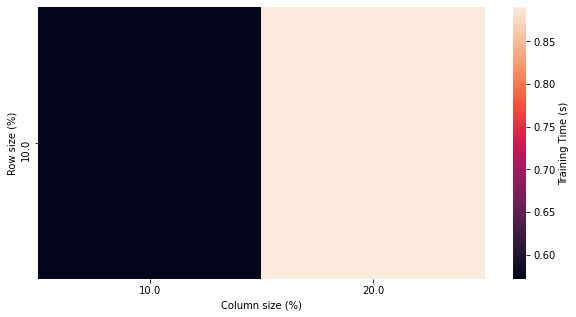

In [44]:
# Visualize the traininig times in a heatmap
plt.figure(figsize=(10, 5))
result = df_results.pivot(index='Row Size', columns='Column Size', values='Training Time')
ax = sns.heatmap(result, cbar_kws={'label': 'Training Time (s)'})
ax.invert_yaxis()
plt.ylabel('Row size (%)')
plt.xlabel('Column size (%)')
plt.savefig('heatmap_training_time.jpg')
plt.show()

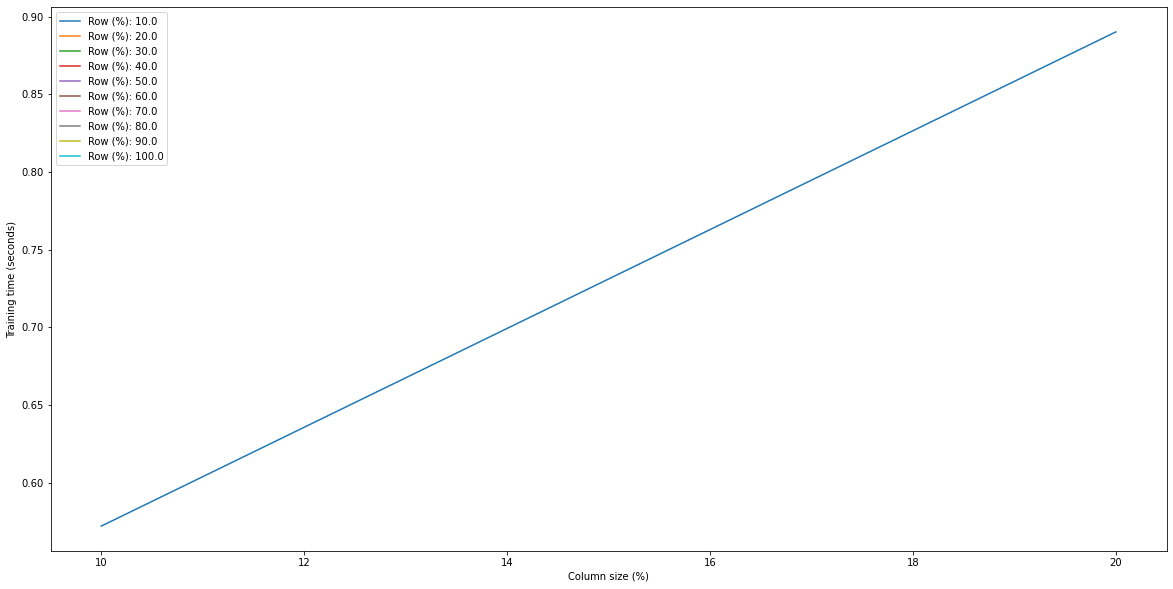

In [45]:
# visualize the training time vs columns
plt.figure(figsize=(20, 10))

for row_size in np.arange(0.1, 1.1, step_size):
    label = 'Row (%): ' + str(round(row_size*100))
    df_results[df_results['Row Size'] == round(row_size*100)].set_index(
        'Column Size')['Training Time'].plot(label=label).legend()
    
plt.ylabel('Training time (seconds)')
plt.xlabel('Column size (%)')
plt.savefig('time_vs_column.jpg')
plt.show()

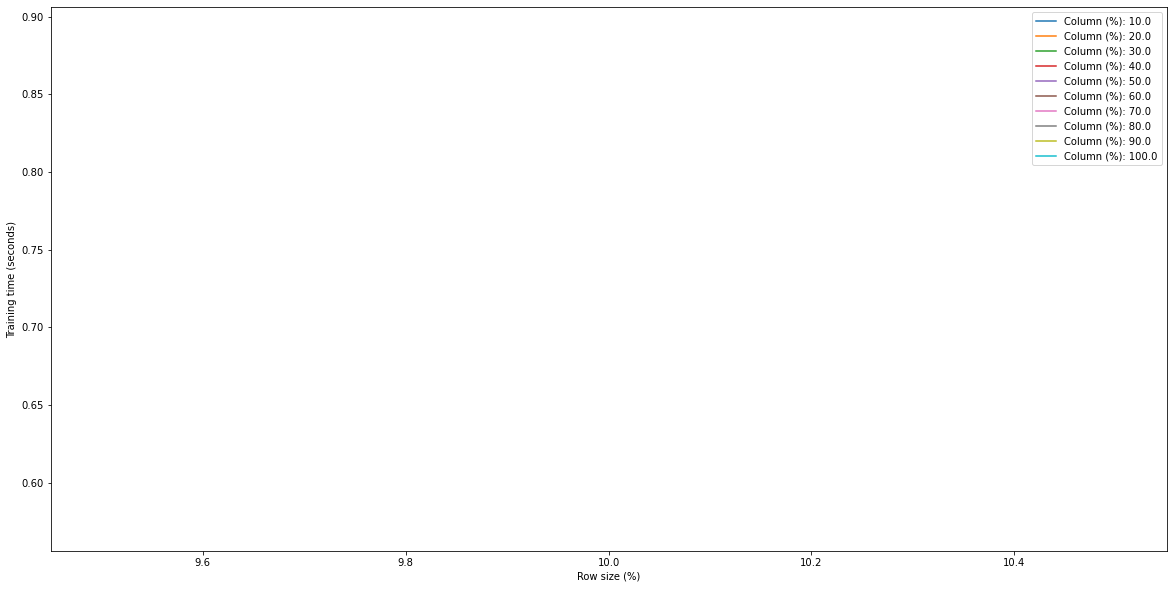

In [46]:
# visualize training time vs rows
plt.figure(figsize=(20, 10))

for column_size in np.arange(0.1, 1.1, step_size):
    label = 'Column (%): ' + str(round(column_size*100))
    df_results[df_results['Column Size'] == round(100*column_size)].set_index(
        'Row Size')['Training Time'].plot(label=label).legend()
    
plt.ylabel('Training time (seconds)')
plt.xlabel('Row size (%)')
plt.savefig('time_vs_row.jpg')
plt.show()

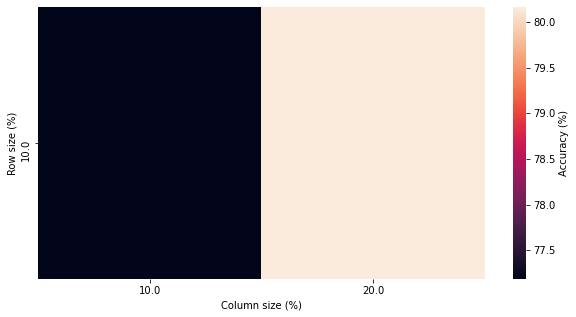

In [48]:
# Visualize the accuracies in a heatmap
plt.figure(figsize=(10, 5))
result = df_results.pivot(index='Row Size', columns='Column Size', values='Accuracy')
ax = sns.heatmap(result, cbar_kws={'label': 'Accuracy (%)'})
ax.invert_yaxis()
plt.ylabel('Row size (%)')
plt.xlabel('Column size (%)')
plt.savefig('heatmap_accuracy.jpg')
plt.show()

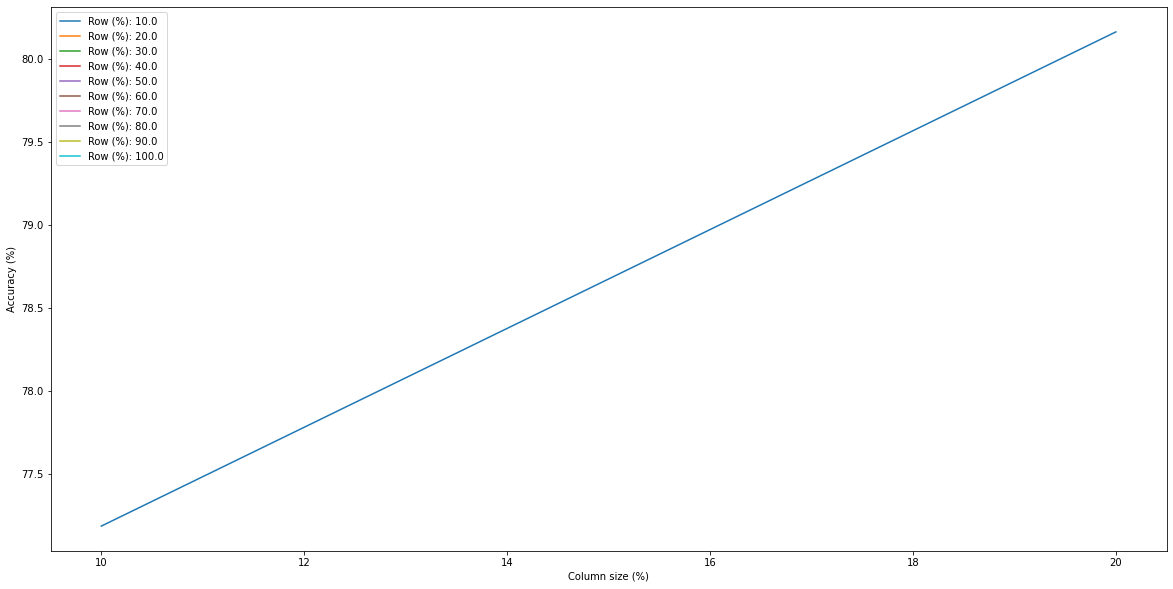

In [49]:
# visualize the accuracy vs columns
plt.figure(figsize=(20, 10))

for row_size in np.arange(0.1, 1.1, step_size):
    label = 'Row (%): ' + str(round(row_size*100))
    df_results[df_results['Row Size'] == round(row_size*100)].set_index(
        'Column Size')['Accuracy'].plot(label=label).legend()
    
plt.ylabel('Accuracy (%)')
plt.xlabel('Column size (%)')
plt.savefig('accuracy_vs_column.jpg')
plt.show()

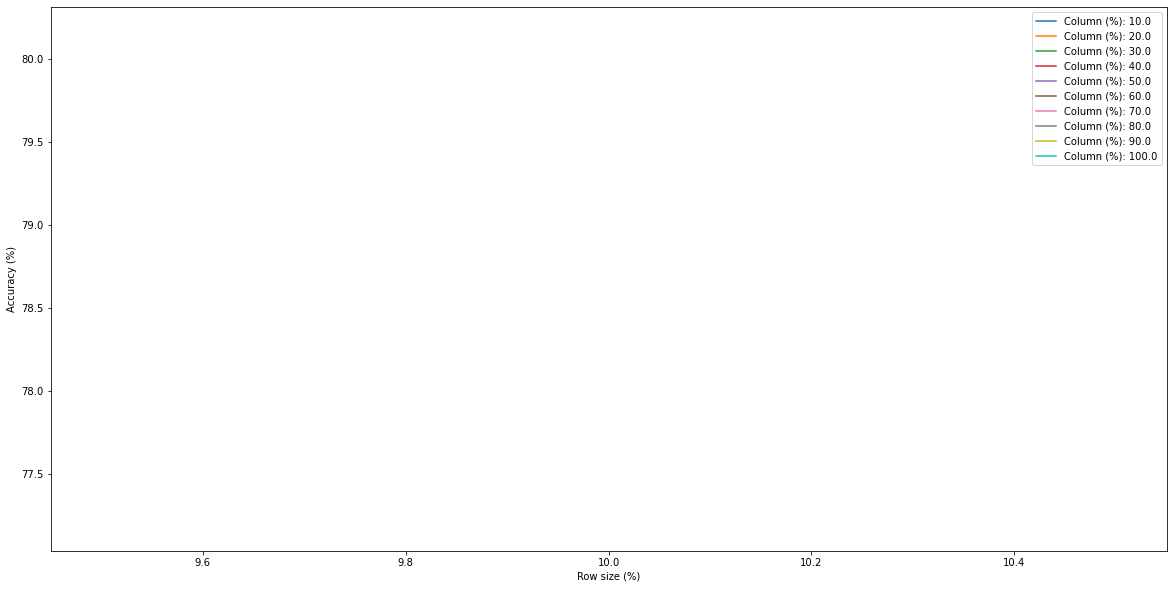

In [50]:
# visualize the accuracy vs rows
plt.figure(figsize=(20, 10))

for column_size in np.arange(0.1, 1.1, step_size):
    label = 'Column (%): ' + str(round(column_size*100))
    df_results[df_results['Column Size'] == round(100*column_size)].set_index(
        'Row Size')['Accuracy'].plot(label=label).legend()
    
plt.ylabel('Accuracy (%)')
plt.xlabel('Row size (%)')
plt.savefig('accuracy_vs_row.jpg')
plt.show()

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [15]:
sns.__version__

'0.10.1'

In [8]:
import sklearn